In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torchvision, torch

In [21]:
import torchsummary

In [30]:
import hiddenlayer as hl

In [3]:
import sys, os
sys.path.insert(0,"../torchxrayvision/")
import torchxrayvision as xrv
import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F
import glob
import numpy as np
import skimage, skimage.filters
%matplotlib inline
import captum, captum.attr
import torch, torch.nn
import pickle
import attribution
import pandas as pd
import datasets
import shutil
import json
import glob

In [4]:
dmerge = datasets.get_data("nih")

NIH_Dataset num_samples=67310 views=['PA'] data_aug=None


In [5]:
dmerge

{'Atelectasis': {0.0: 61582, 1.0: 5728},
 'Cardiomegaly': {0.0: 65747, 1.0: 1563},
 'Consolidation': {0.0: 65789, 1.0: 1521},
 'Edema': {0.0: 67034, 1.0: 276},
 'Effusion': {0.0: 60721, 1.0: 6589},
 'Emphysema': {0.0: 65811, 1.0: 1499},
 'Fibrosis': {0.0: 65902, 1.0: 1408},
 'Hernia': {0.0: 67118, 1.0: 192},
 'Infiltration': {0.0: 57957, 1.0: 9353},
 'Mass': {0.0: 63743, 1.0: 3567},
 'Nodule': {0.0: 63133, 1.0: 4177},
 'Pleural_Thickening': {0.0: 64892, 1.0: 2418},
 'Pneumonia': {0.0: 66680, 1.0: 630},
 'Pneumothorax': {0.0: 63903, 1.0: 3407}}


NIH_Dataset num_samples=67310 views=['PA'] data_aug=None

In [6]:
ae = xrv.autoencoders.ResNetAE(weights="101-elastic").cuda()

In [76]:
models = [xrv.models.DenseNet(weights="all").cuda(),
          xrv.baseline_models.jfhealthcare.DenseNet().cuda()]
models_toreset = [xrv.models.DenseNet(weights="all").cuda(),
                  xrv.baseline_models.jfhealthcare.DenseNet().cuda()]

In [77]:
model = models[0]
model_toreset=models_toreset[0]
print(model.pathologies)
print(model,model_toreset)

['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'Lung Lesion', 'Fracture', 'Lung Opacity', 'Enlarged Cardiomediastinum']
XRV-DenseNet121-all XRV-DenseNet121-all


In [74]:
# display hierarchical structure of this model up to level of detail
# these keys can be used to specify which part to reset
sd=model.state_dict()
last_item=''
for k,v in sd.items():
    A=k.split('.')
    limit=2
    if len(A)>2 and 'dense' in A[2]:
        limit=3
    S=".".join(A[:min(len(A),limit)] + (['*'] if len(A)>limit else []))
    if S!=last_item:
        print(S)
        last_item=S
    #print(k,type(v))


op_threshs
features.conv0.*
features.norm0.*
features.denseblock1.denselayer1.*
features.denseblock1.denselayer2.*
features.denseblock1.denselayer3.*
features.denseblock1.denselayer4.*
features.denseblock1.denselayer5.*
features.denseblock1.denselayer6.*
features.transition1.*
features.denseblock2.denselayer1.*
features.denseblock2.denselayer2.*
features.denseblock2.denselayer3.*
features.denseblock2.denselayer4.*
features.denseblock2.denselayer5.*
features.denseblock2.denselayer6.*
features.denseblock2.denselayer7.*
features.denseblock2.denselayer8.*
features.denseblock2.denselayer9.*
features.denseblock2.denselayer10.*
features.denseblock2.denselayer11.*
features.denseblock2.denselayer12.*
features.transition2.*
features.denseblock3.denselayer1.*
features.denseblock3.denselayer2.*
features.denseblock3.denselayer3.*
features.denseblock3.denselayer4.*
features.denseblock3.denselayer5.*
features.denseblock3.denselayer6.*
features.denseblock3.denselayer7.*
features.denseblock3.denselayer

In [95]:
def weight_randomizer(model,key):
    print("Reinitializing",key)
    keylist=key.split('.')
    M=model
    for k in keylist:
        M=M._modules[k]
    for i,m in enumerate(M.modules()):
        if isinstance(m, torch.nn.Conv2d):
            #print(f"===================================== {i} ==============================")
            #print(m)
            print("----Conv2d")
            m.reset_parameters()
            #torch.nn.init.kaiming_normal_(m.weight)
        elif isinstance(m, torch.nn.BatchNorm2d):
            #print(f"===================================== {i} ==============================")
            #print(m)
            print("----BatchNorm2d")
            m.reset_parameters()
            #torch.nn.init.constant_(m.weight, 1)
            #torch.nn.init.constant_(m.bias, 0)
        elif isinstance(m, torch.nn.Linear):
            #print(f"===================================== {i} ==============================")
            #print(m)
            print("----Linear")
            m.reset_parameters()
            #torch.nn.init.kaiming_normal_(m.weight)
            #torch.nn.init.constant_(m.bias, 0)


In [79]:
for_eval = [
            "Cardiomegaly",
            "Atelectasis",
            "Effusion",
            "Consolidation",
            "Edema",
            "Mass"
            ]

In [80]:
model.pathologies

['Atelectasis',
 'Consolidation',
 'Infiltration',
 'Pneumothorax',
 'Edema',
 'Emphysema',
 'Fibrosis',
 'Effusion',
 'Pneumonia',
 'Pleural_Thickening',
 'Cardiomegaly',
 'Nodule',
 'Mass',
 'Hernia',
 'Lung Lesion',
 'Fracture',
 'Lung Opacity',
 'Enlarged Cardiomediastinum']

In [81]:
for_eval

['Cardiomegaly', 'Atelectasis', 'Effusion', 'Consolidation', 'Edema', 'Mass']

In [82]:
methods = ["image", "grad", "guided", "integrated", "latentshift-max"]
temp_path = "/carl/rupert_brooks/output/temp"

tensor([0.5100])
[0.44826764] -370 20


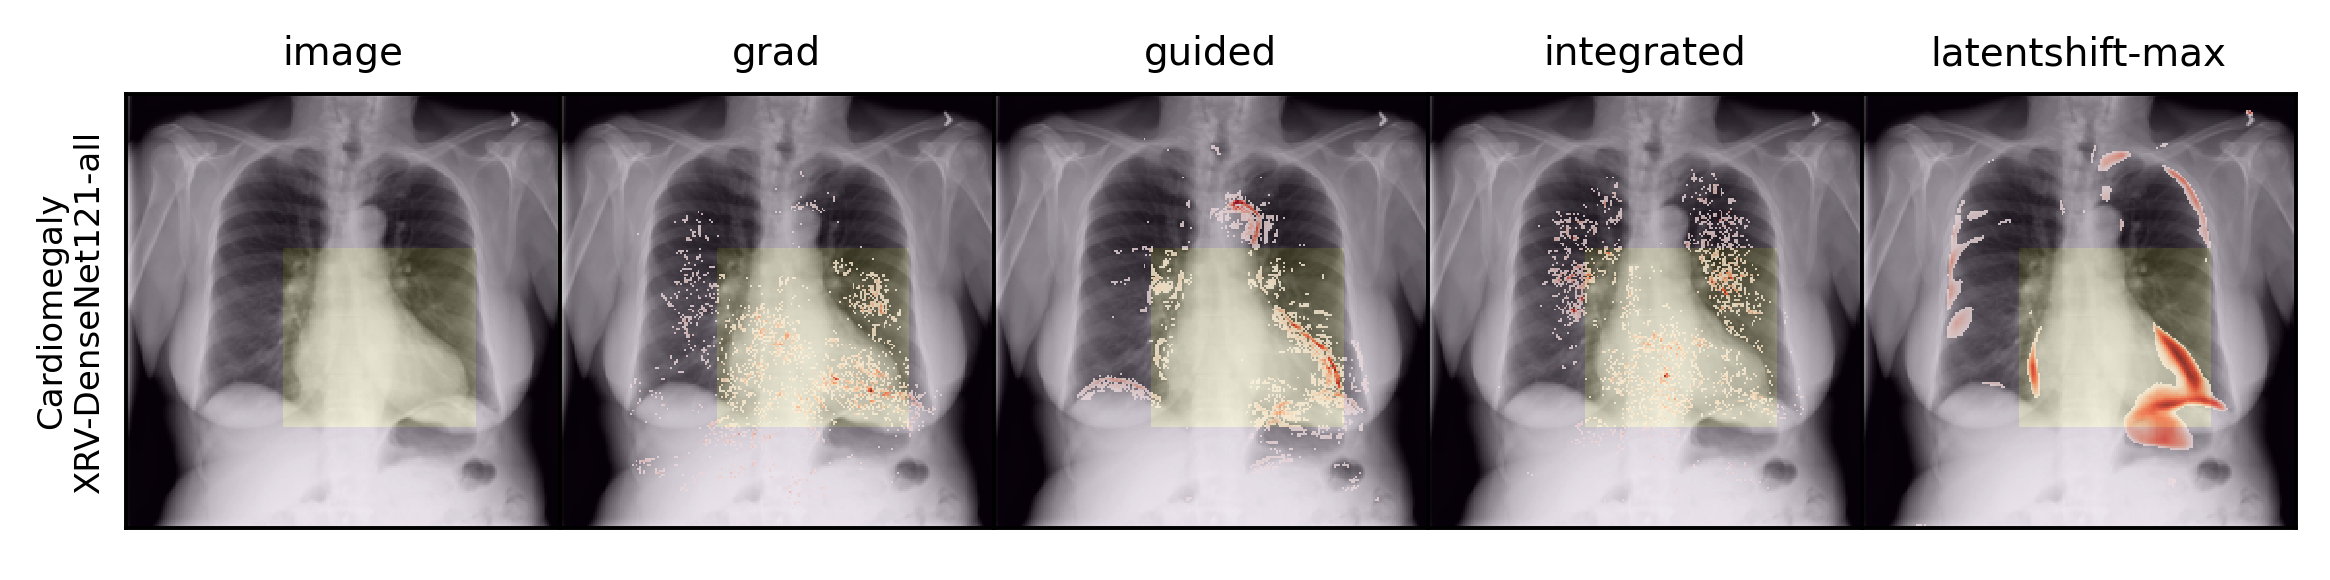

In [83]:
target = "Cardiomegaly"
label = 1
dwhere = np.where(dmerge.csv.has_masks & (dmerge.labels[:,dmerge.pathologies.index(target)]  == 1))[0]
idx = 5
sample = dmerge[dwhere[idx]]
model = models[0]
attribution.generate_attributions(sample, model, target, ae, temp_path, dmerge)

tensor([0.7554])
[0.7692515] -1000 1000


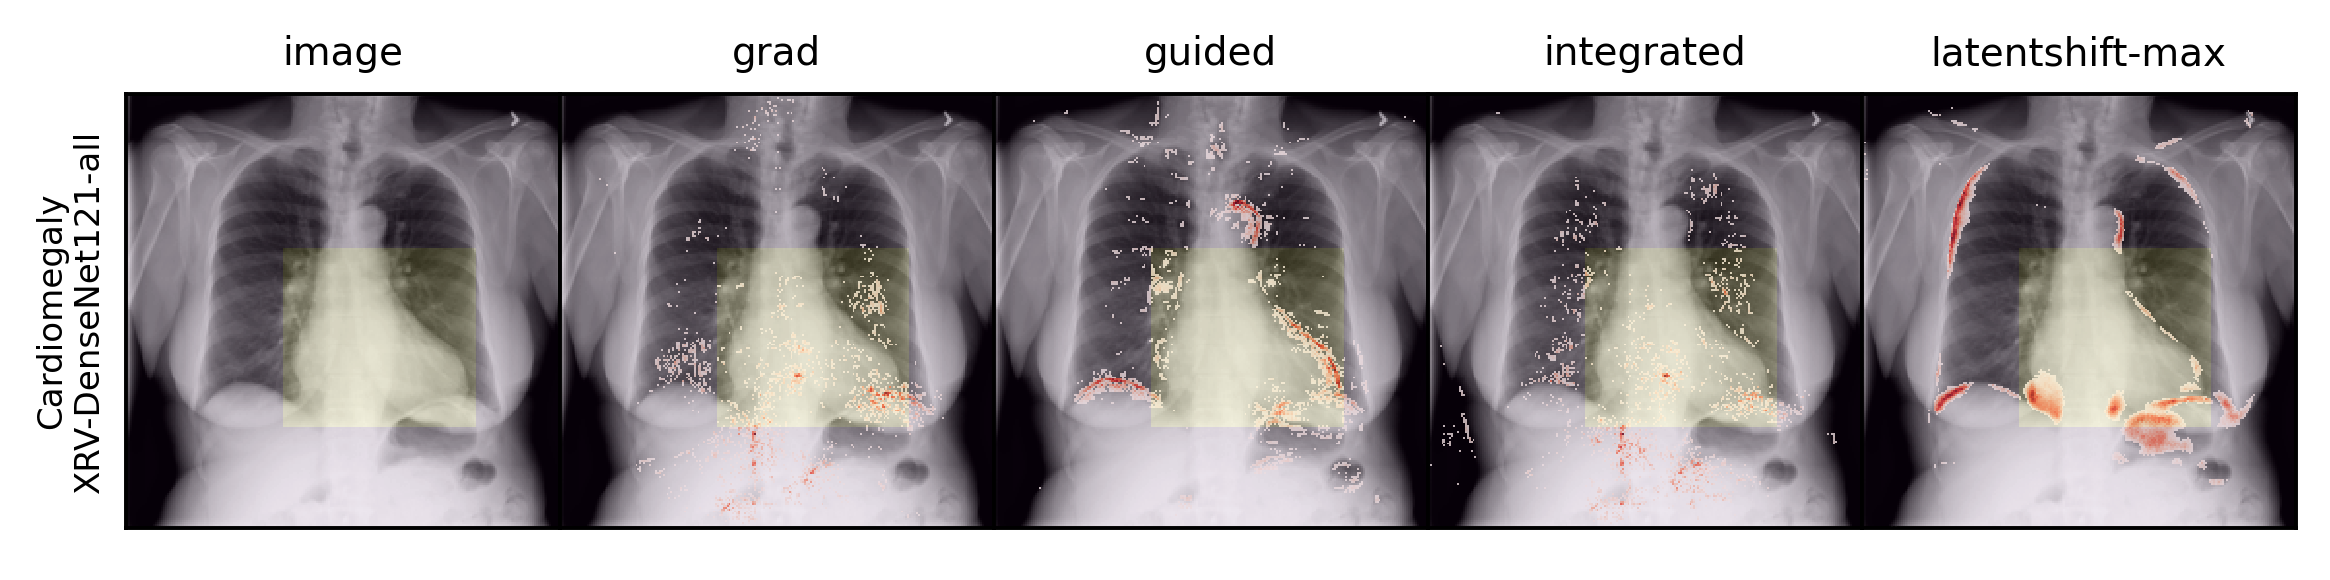

In [97]:
# in Adebayo et al, they start near the output and start resetting layers
# the less the attribution changes, the less valid it is
model_toreset.load_state_dict(model.state_dict())
weight_randomizer(model_toreset,'classifier')
attribution.generate_attributions(sample, model_toreset, target, ae, temp_path, dmerge)

Reinitializing features.norm5
----BatchNorm2d
tensor([0.7554])
[0.7692515] -1000 1000


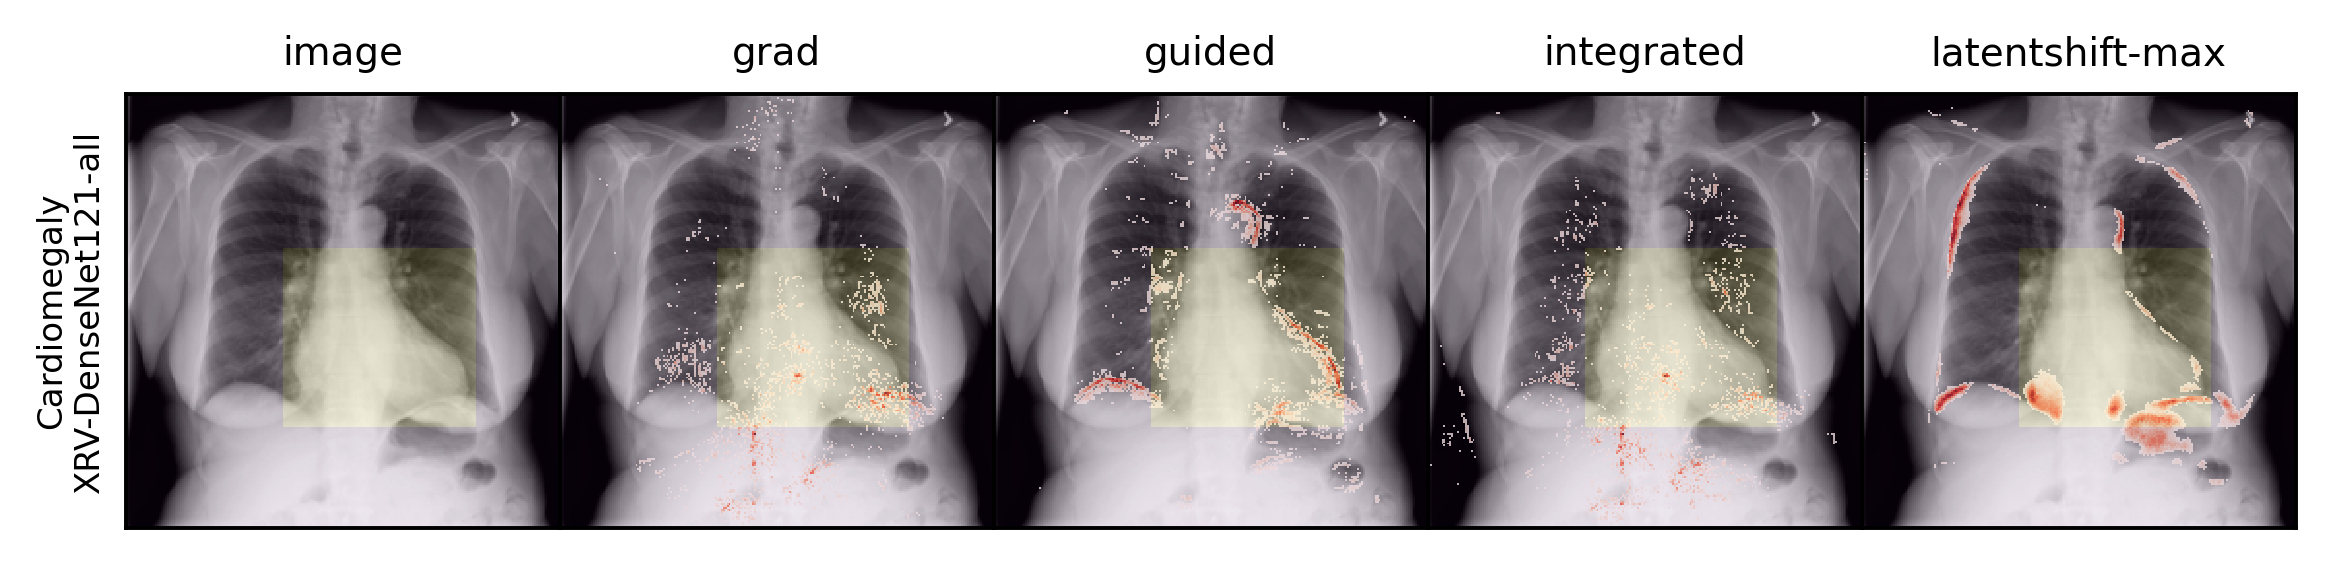

In [98]:
weight_randomizer(model_toreset,'features.norm5')
attribution.generate_attributions(sample, model_toreset, target, ae, temp_path, dmerge)

Reinitializing features.denseblock4.denselayer16
----BatchNorm2d
----Conv2d
----BatchNorm2d
----Conv2d
tensor([0.7578])
[0.77272606] -1000 1000


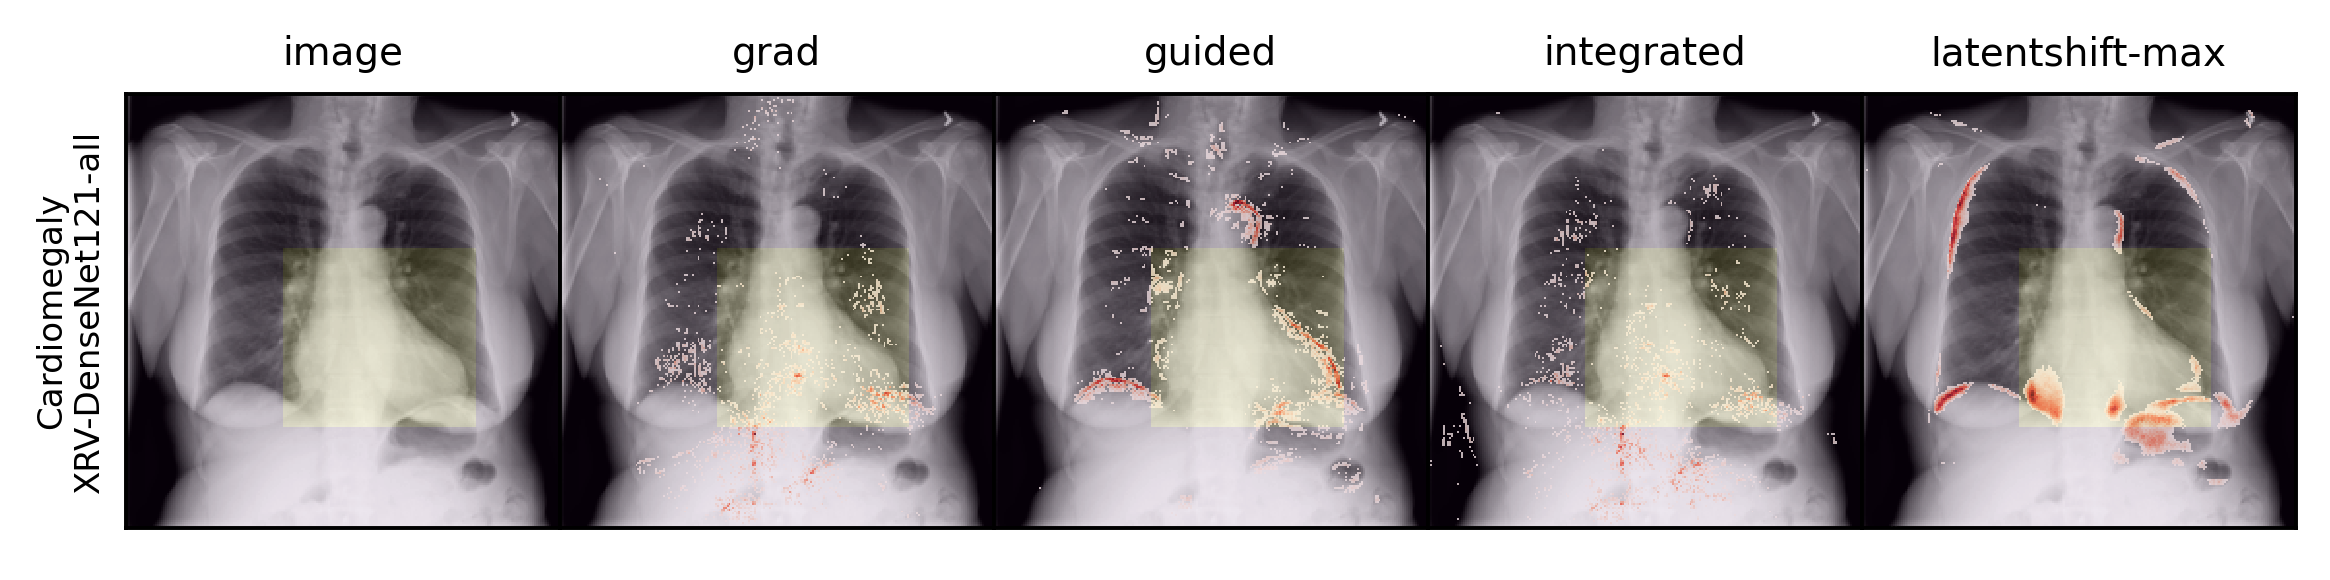

In [99]:
weight_randomizer(model_toreset,'features.denseblock4.denselayer16')
attribution.generate_attributions(sample, model_toreset, target, ae, temp_path, dmerge)

tensor([0.5100])
[0.44826764] -370 20


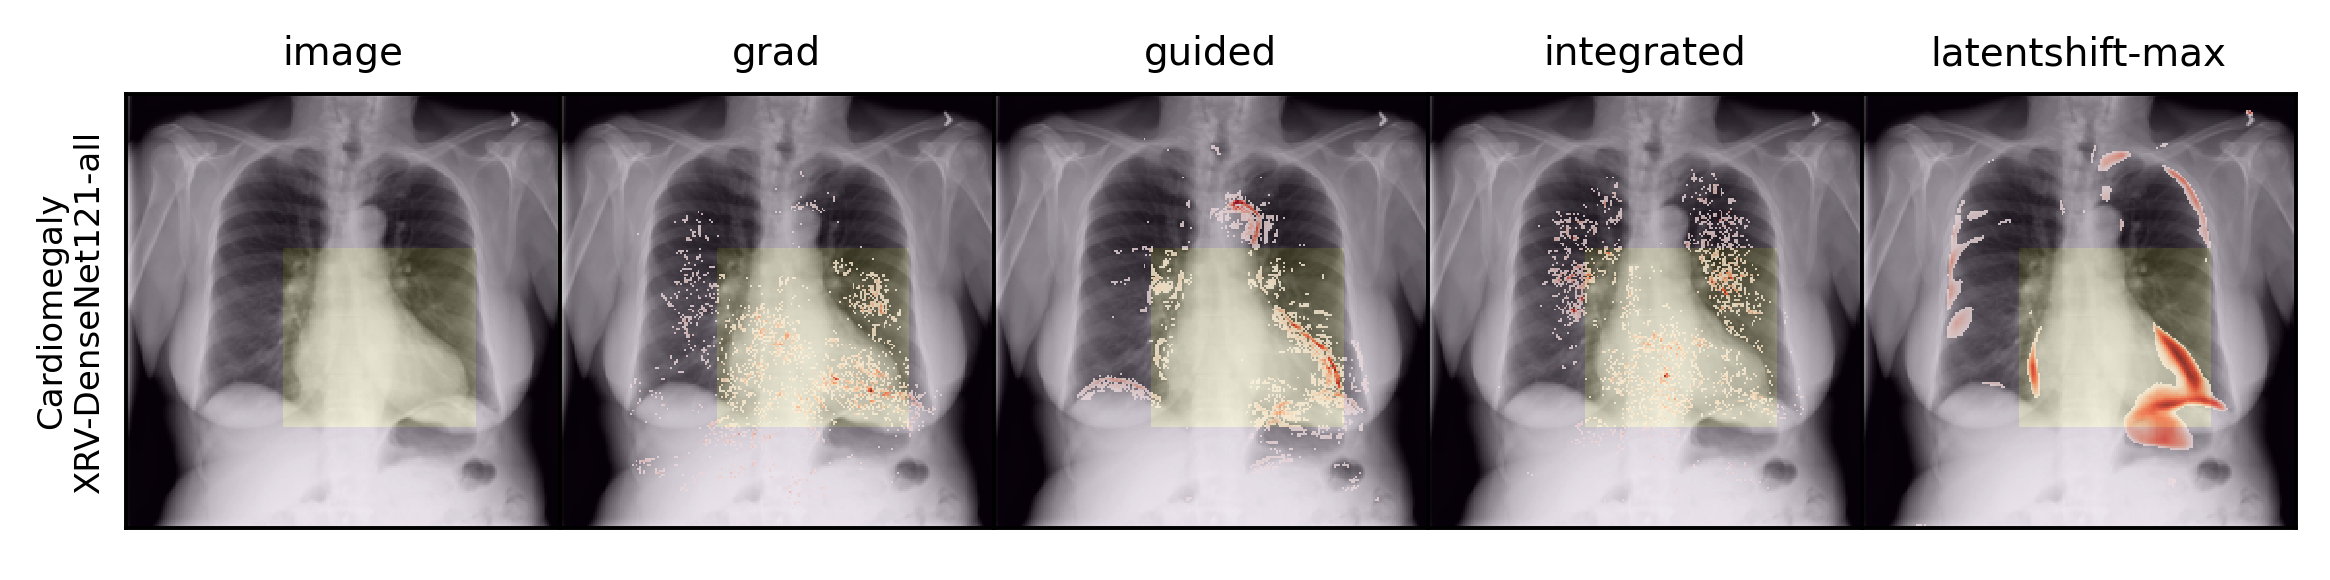

tensor([0.3266])
[0.11226087] -660 250


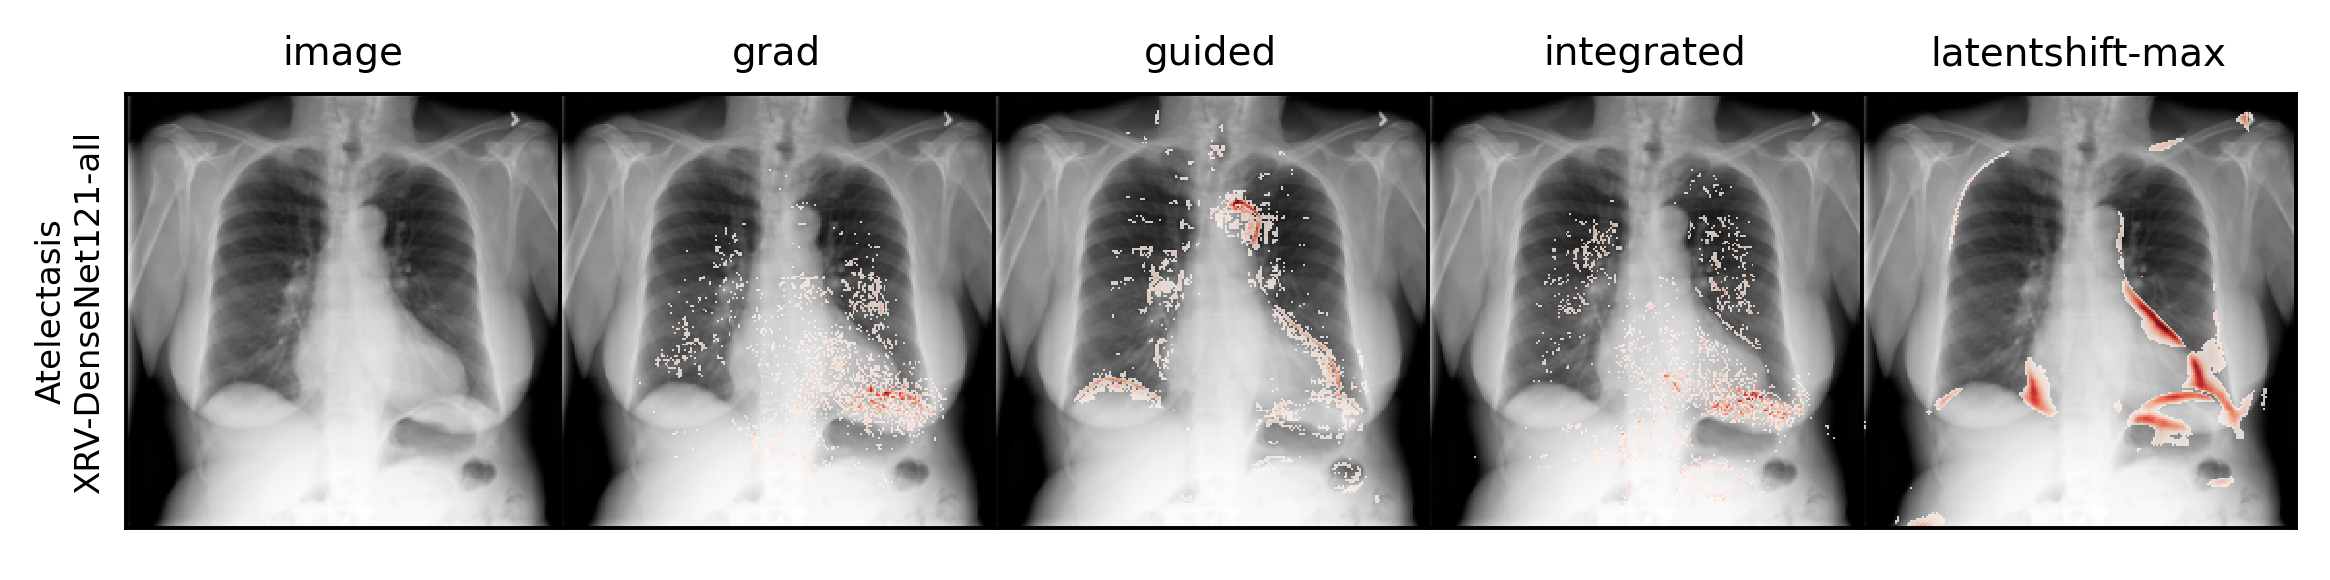

tensor([0.1654])
[0.10648435] -1000 150


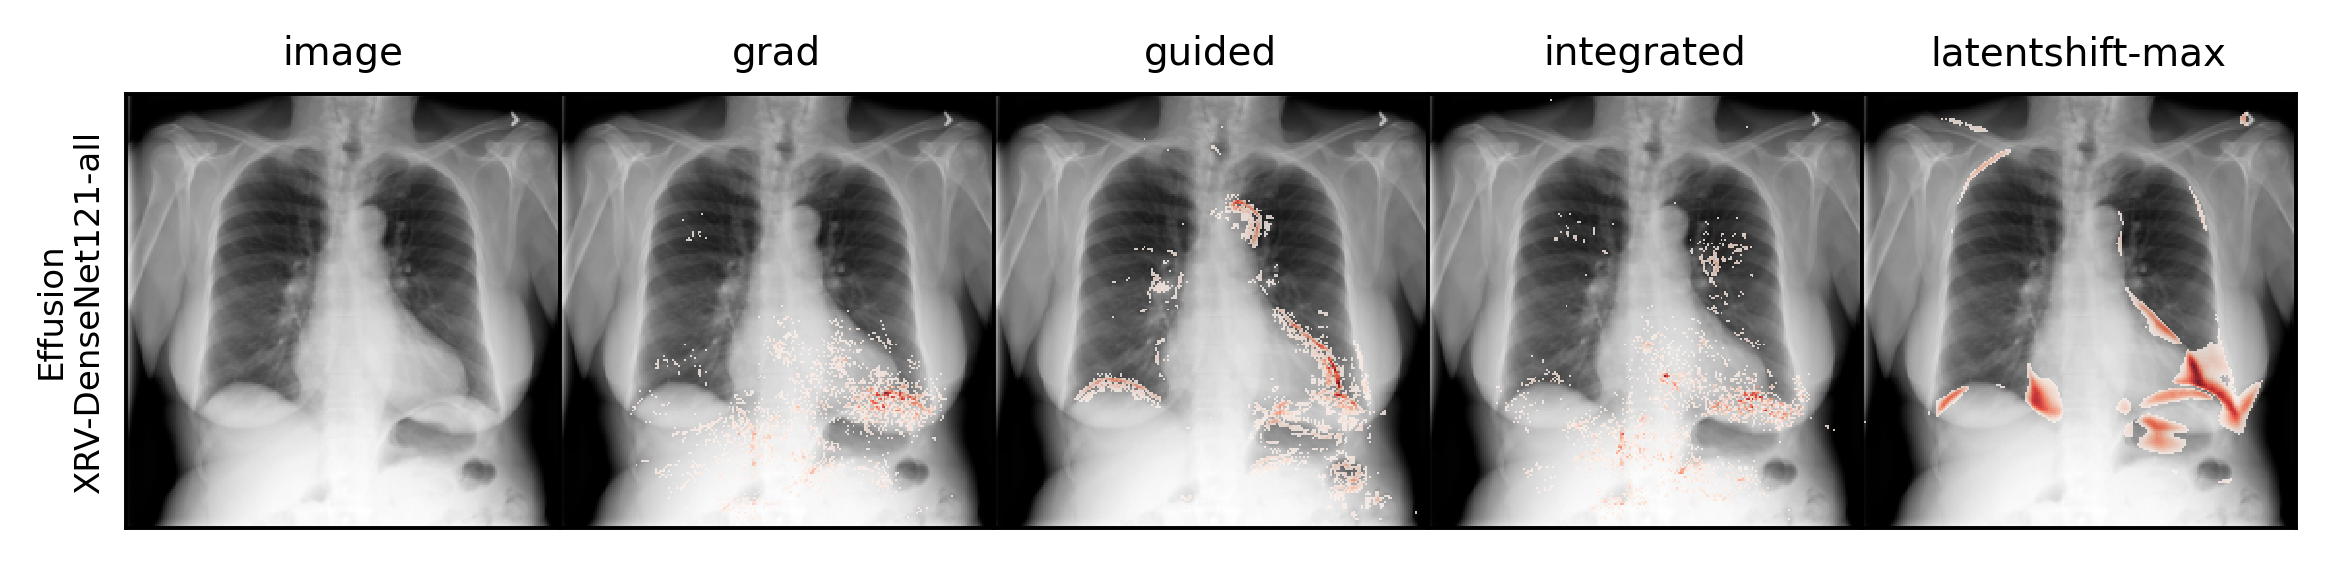

tensor([0.1127])
[0.06264362] -1000 1000


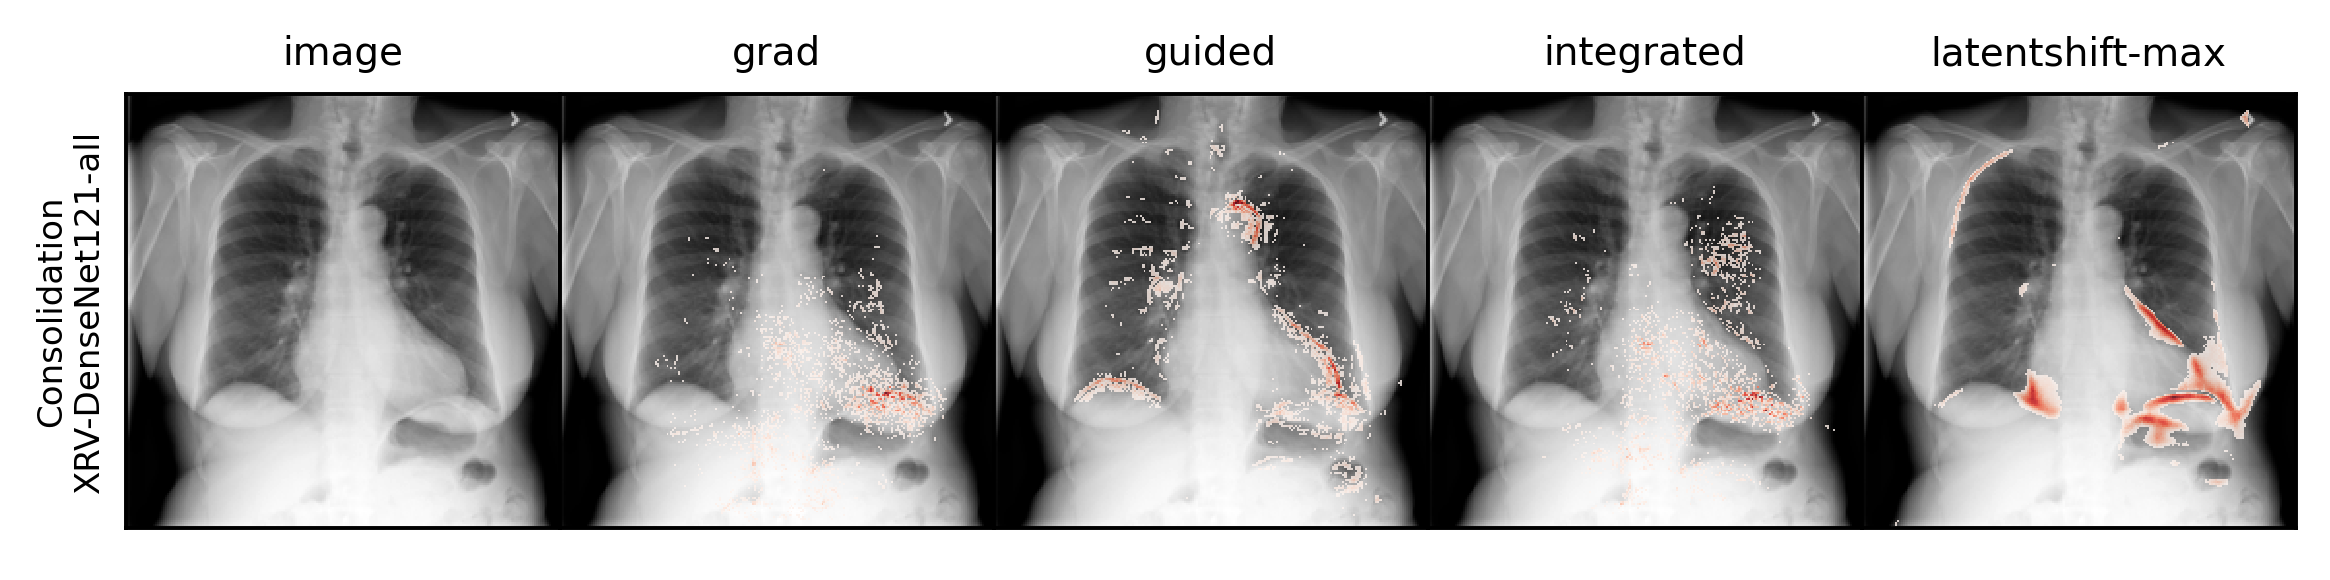

tensor([0.0093])
[0.00239053] -1000 1000


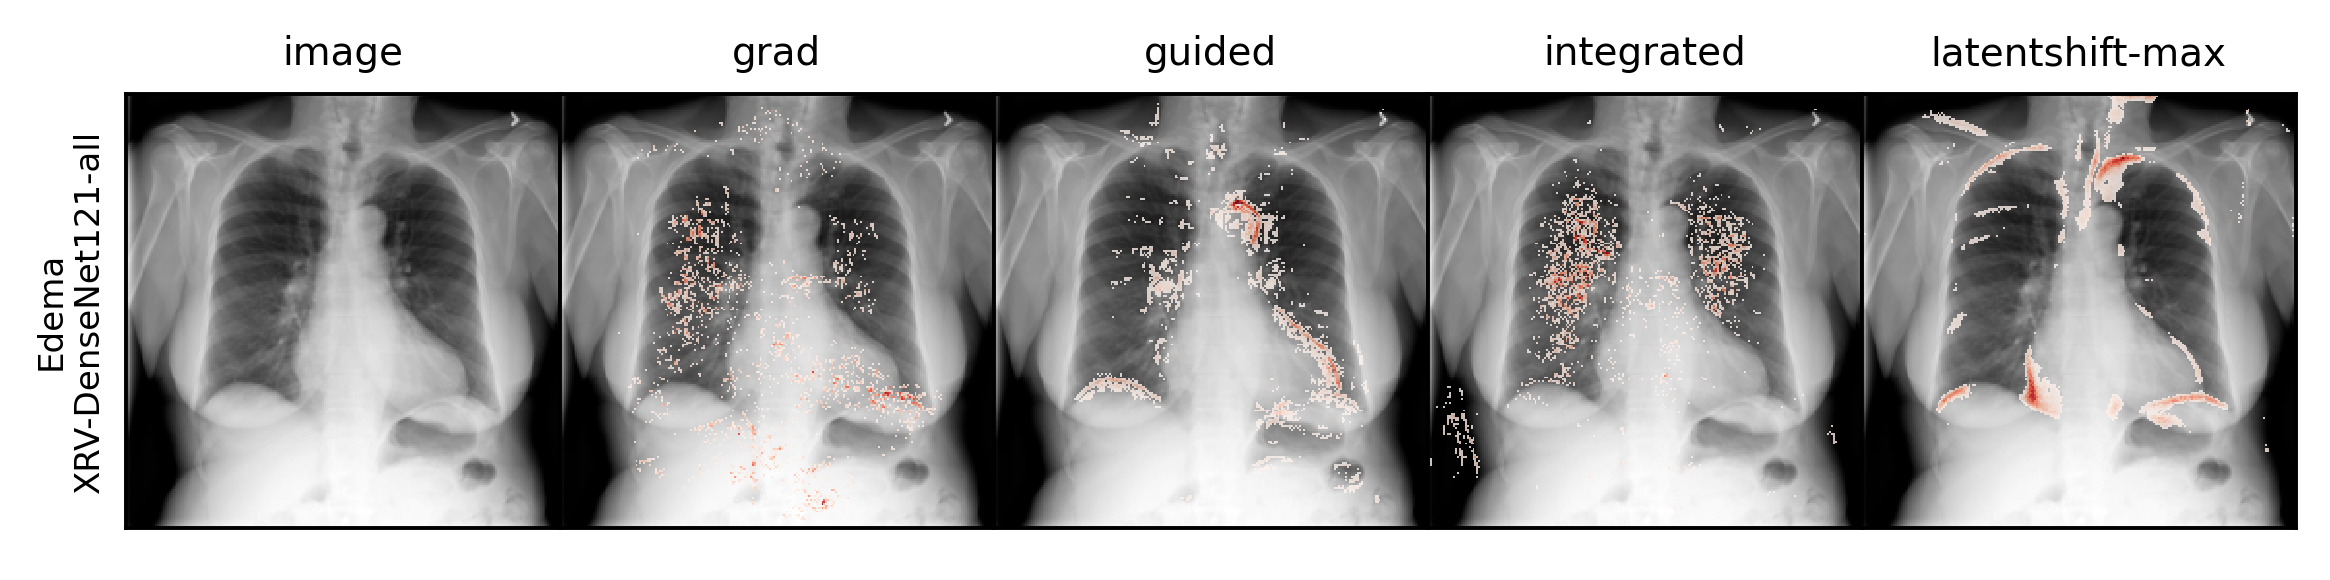

tensor([0.3158])
[0.13661185] -320 150


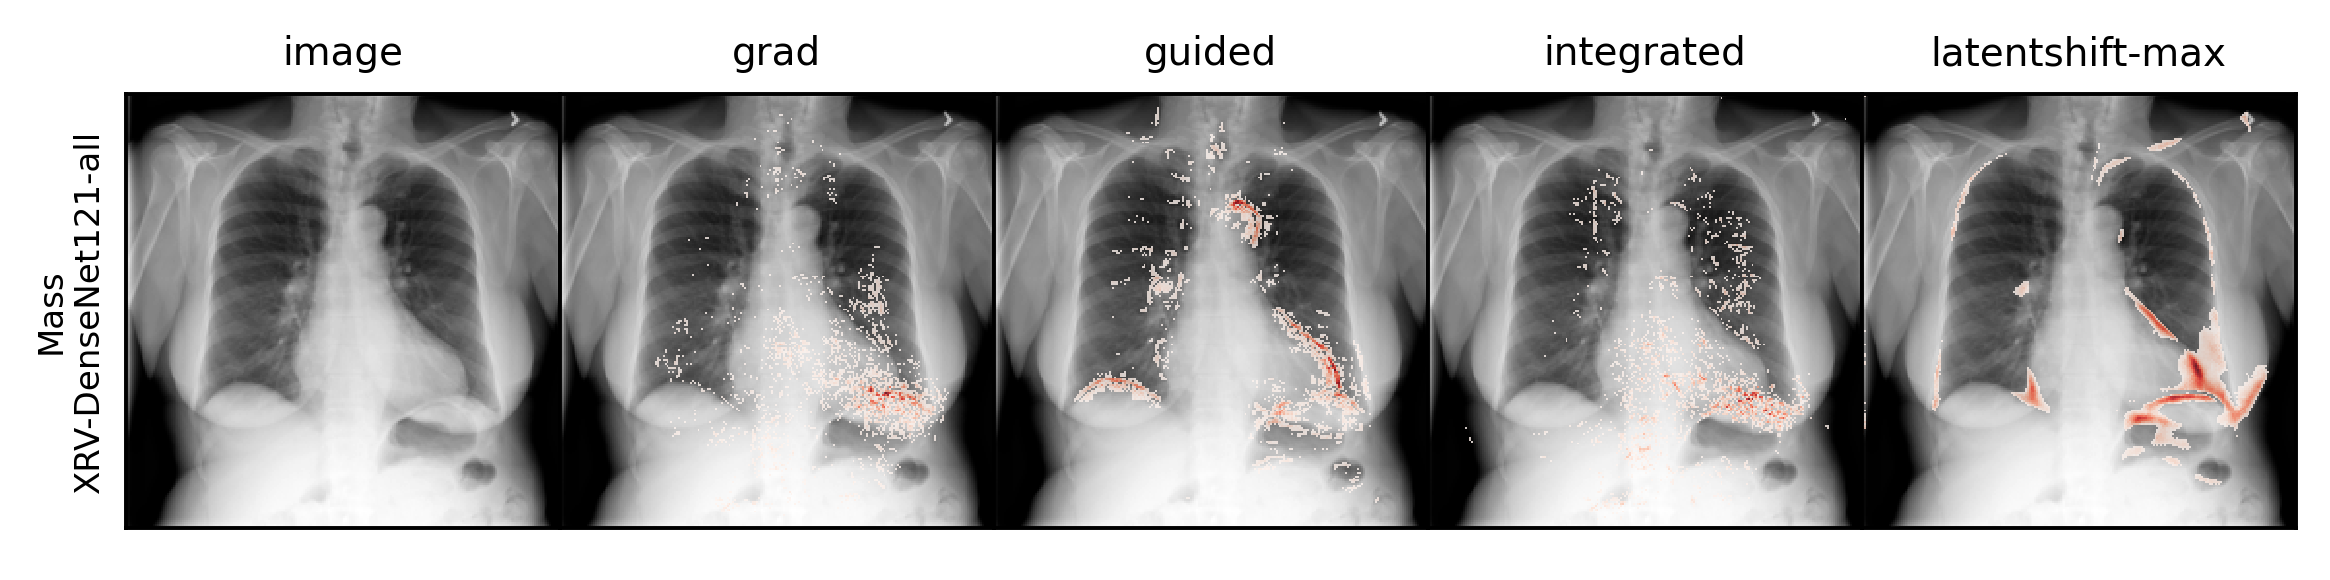

In [101]:
# Adebayo et al also compare to the attribution map generated by a network trained on random labels
# Training is not working yet, but if the attribution maps differ, for this image, for other classes
for trg in for_eval:
    attribution.generate_attributions(sample, model, trg, ae, temp_path, dmerge)


In [ ]:
# ----------------------- New material ends here.

tensor([0.7834])
[0.47765264] -150 250


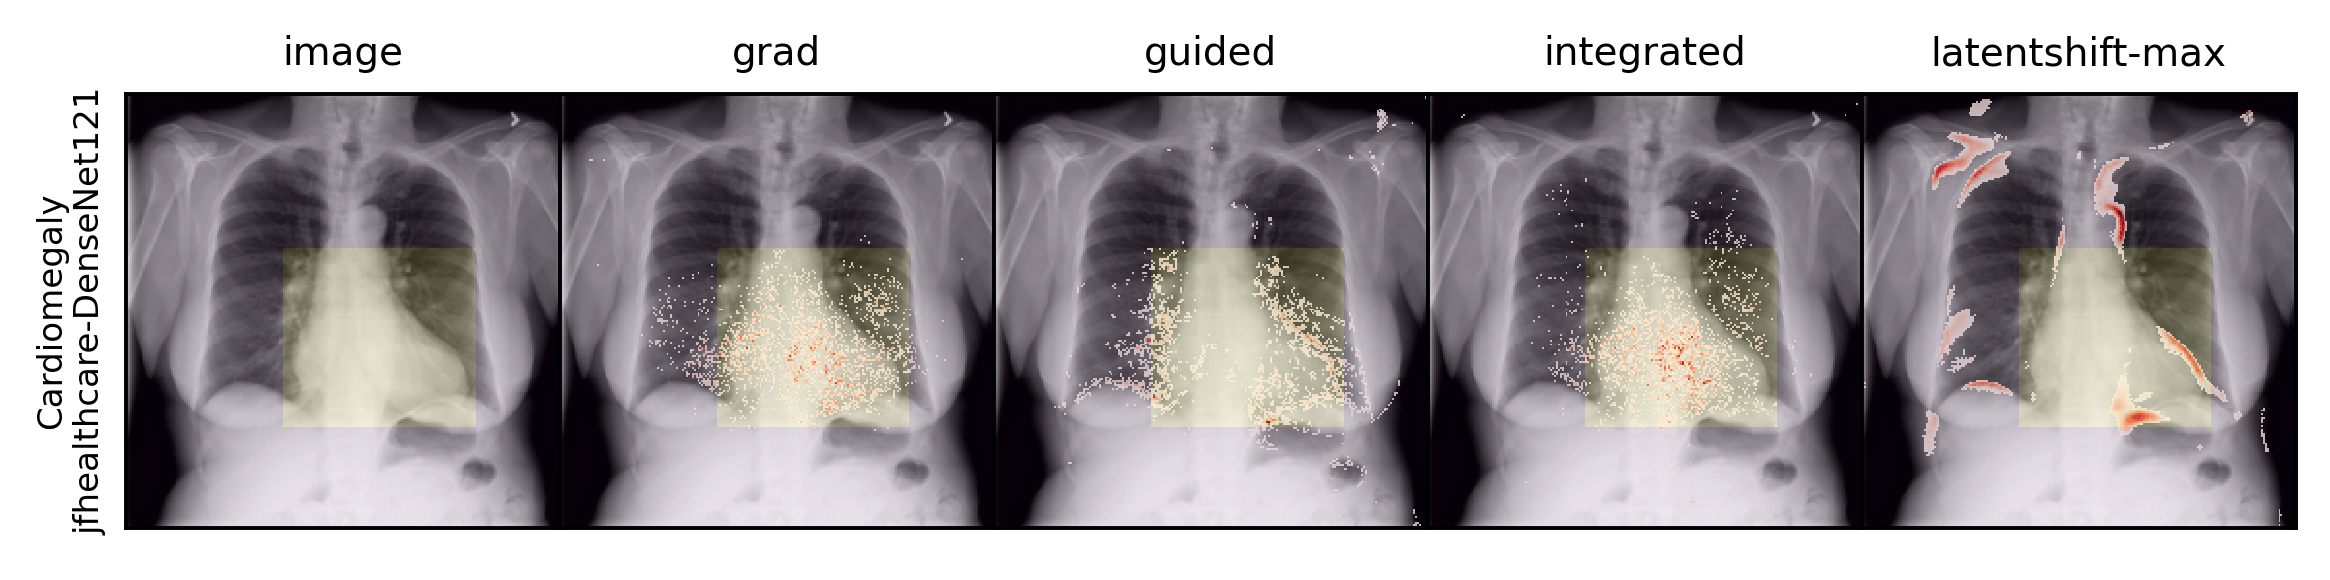

In [14]:
target = "Cardiomegaly"
label = 1
dwhere = np.where(dmerge.csv.has_masks & (dmerge.labels[:,dmerge.pathologies.index(target)]  == 1))[0]
idx = 5
sample = dmerge[dwhere[idx]]
model = models[1]
attribution.generate_attributions(sample, model, target, ae, temp_path, dmerge)

tensor([0.8052])
[0.5680183] -890 210


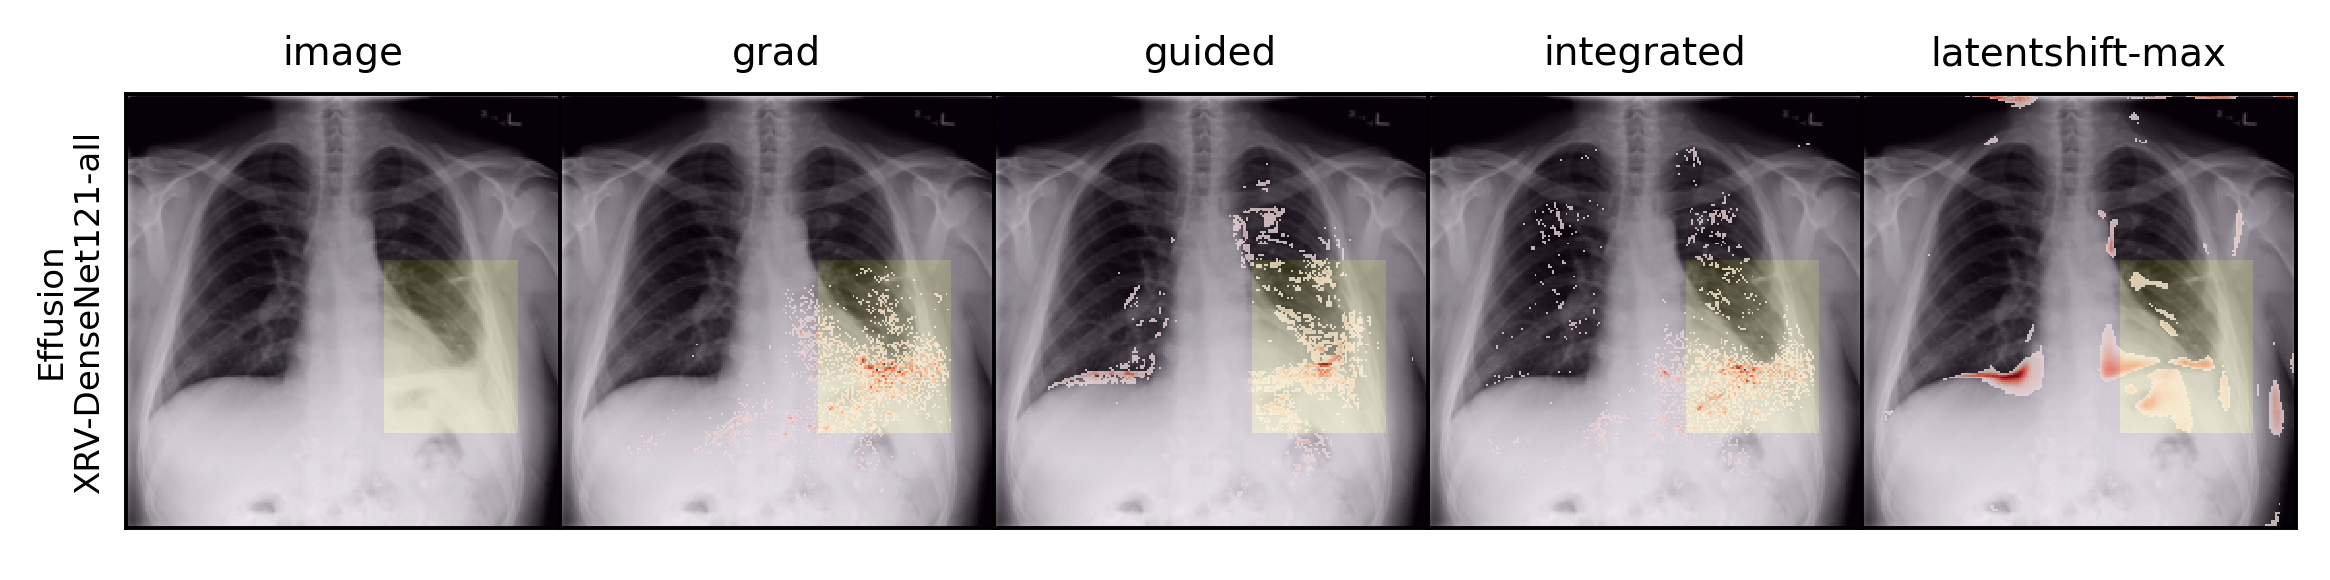

In [15]:
target = "Effusion"
label = 1
dwhere = np.where(dmerge.csv.has_masks & (dmerge.labels[:,dmerge.pathologies.index(target)]  == 1))[0]
idx = 8
sample = dmerge[dwhere[idx]]
model = models[0]
attribution.generate_attributions(sample, model, target, ae, temp_path, dmerge)

tensor([0.8102])
[0.40092975] -380 40


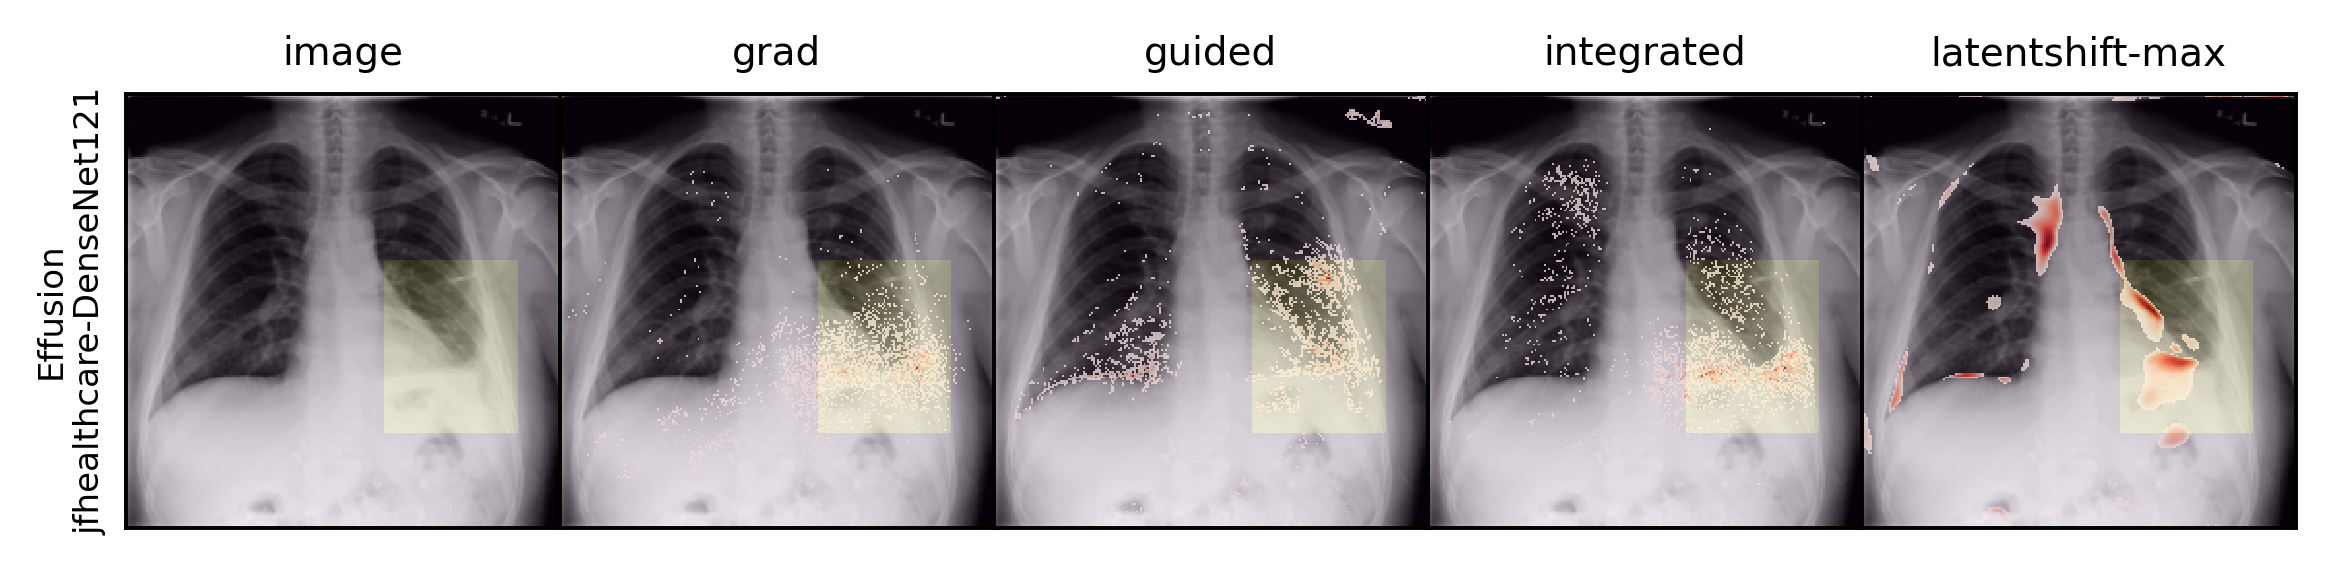

In [16]:
target = "Effusion"
label = 1
dwhere = np.where(dmerge.csv.has_masks & (dmerge.labels[:,dmerge.pathologies.index(target)]  == 1))[0]
idx = 8
sample = dmerge[dwhere[idx]]
model = models[1]
attribution.generate_attributions(sample, model, target, ae, temp_path, dmerge)